# Modeling the disparity between experienced and residential nativity segregation

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\mobi-social-segregation-se

D:\mobi-social-segregation-se


In [2]:
# Load libs
import pandas as pd
import numpy as np
from tqdm import tqdm
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from interpret.glassbox import ExplainableBoostingRegressor
import seaborn as sns
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
font = {'size': 14}
mpl.rc('font', **font)

In [4]:
df_exp = pd.read_parquet('results/data4model_individual.parquet')
df_exp = df_exp.loc[(df_exp['weekday'] == 1) & (df_exp['holiday'] == 0), :]

## 1. Select variables

In [5]:
cols = ['uid', 'region', 'wt_p',
        'Lowest income group', 'car_ownership', 'radius_of_gyration',
        'cum_jobs', 'cum_stops',
        'ice_birth_resi', 'ice_birth']
df_exp = df_exp[cols]

### 1.1 Add labels of home regions (A, B, and C)
A DeSO in category A is mostly outside major population concentrations or urban areas. DeSO in category B is mostly located in a population concentration or agglomeration, but not in the municipality's central location. Category C includes DeSO, which is mostly located in the municipality's central location. In total, 18 percent of DeSO are found in category A, 10 percent in category B and 72 percent in category C.

Source: [SCB.se](https://www.scb.se/hitta-statistik/regional-statistik-och-kartor/regionala-indelningar/deso---demografiska-statistikomraden/)

In [6]:
df_exp.loc[:, 'deso_2'] = df_exp['region'].apply(lambda x: x[0:2])
df_exp.loc[:, 'region_cat'] = df_exp['region'].apply(lambda x: x[4])

## 2. Grouping segregation patterns

In [7]:
def seg_direction(row):
    if row['ice_birth_resi'] < 0:
        if row['ice_birth'] < 0:
            return 'FF'
        else:
            return 'FD'
    else:
        if row['ice_birth'] < 0:
            return 'DF'
    return 'DD'

def delta_ice(ice_r, ice_e):
    if ice_r < 0:
        return -(ice_e - ice_r)
    return ice_e - ice_r

def seg_abs_direction(x):
    if x >= 0:
        return 'inc'
    return 'dec'

In [8]:
df_exp.loc[:, 'seg_gap'] = df_exp.apply(lambda row: delta_ice(row['ice_birth_resi'], row['ice_birth']), axis=1)
df_exp.loc[:, 'seg_cross'] = df_exp.apply(lambda row: seg_direction(row), axis=1)
df_exp.loc[:, 'seg_change'] = df_exp.apply(lambda row: seg_abs_direction(row['seg_gap']), axis=1)
df_exp.loc[:, 'seg_r'] = df_exp.apply(lambda row: row['seg_cross'][0], axis=1)
df_exp.loc[:, 'region_cat2'] = df_exp['region_cat'].apply(lambda x: 'Rural/Suburban' if x in ('A', 'B') else 'Urban')
df_exp.iloc[0]

uid                    00008608-f79e-414d-bf1c-25632d6bc059
region                                            1284C1040
wt_p                                              84.428571
Lowest income group                                0.088063
car_ownership                                      0.541455
radius_of_gyration                               114.406844
cum_jobs                                        4813.309325
cum_stops                                               3.0
ice_birth_resi                                     0.324146
ice_birth                                          0.041918
deso_2                                                   12
region_cat                                                C
seg_gap                                           -0.282228
seg_cross                                                DD
seg_change                                              dec
seg_r                                                     D
region_cat2                             

### 2.1 Control for income, rg, and car ownership

In [9]:
def eval_k_means(estimator, data, weights):
    estimator.fit(data, sample_weight=weights)
    sc = metrics.silhouette_score(data, estimator.labels_, sample_size=10000, random_state=0)
    return sc, estimator.labels_

In [11]:
cont_grp = df_exp.loc[:, ['Lowest income group', 'car_ownership', 'radius_of_gyration']].values
sample_weight = df_exp['wt_p'].values
scaler = StandardScaler().fit(cont_grp, sample_weight=sample_weight)
cont_grp = scaler.transform(cont_grp)
perf_clusters = []
for n_clusters in tqdm(range(2,7)):
    sc, labels = eval_k_means(KMeans(n_clusters=n_clusters, random_state=0, n_init=10),
                              weights=sample_weight, data=cont_grp)
    perf_clusters.append((n_clusters, sc))
df_cls = pd.DataFrame(perf_clusters, columns=['Number of clusters', 'Silhouette score'])

100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


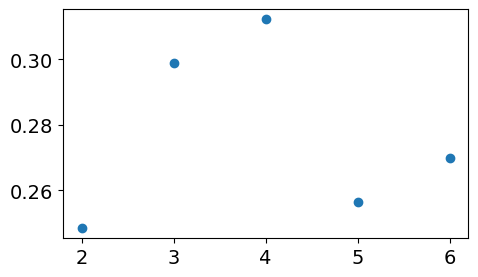

In [12]:
fig = plt.figure(figsize=(5, 3))
plt.scatter(df_cls['Number of clusters'], df_cls['Silhouette score'])
plt.tight_layout()
plt.show()

Choose three clusters

In [13]:
sc, labels = eval_k_means(KMeans(n_clusters=3, random_state=0, n_init=10), weights=sample_weight, data=cont_grp)
print(sc)

0.29900930909737156


In [14]:
df_exp.loc[:, 'ctrl_grp'] = labels

In [15]:
df_exp.groupby('ctrl_grp')[['Lowest income group', 'car_ownership', 'radius_of_gyration']].median()

,Lowest income group,car_ownership,radius_of_gyration
ctrl_grp,,,
0,0.187500,0.796791,41.986808
1,0.469314,0.425245,39.820310
2,0.178110,0.390737,64.970388


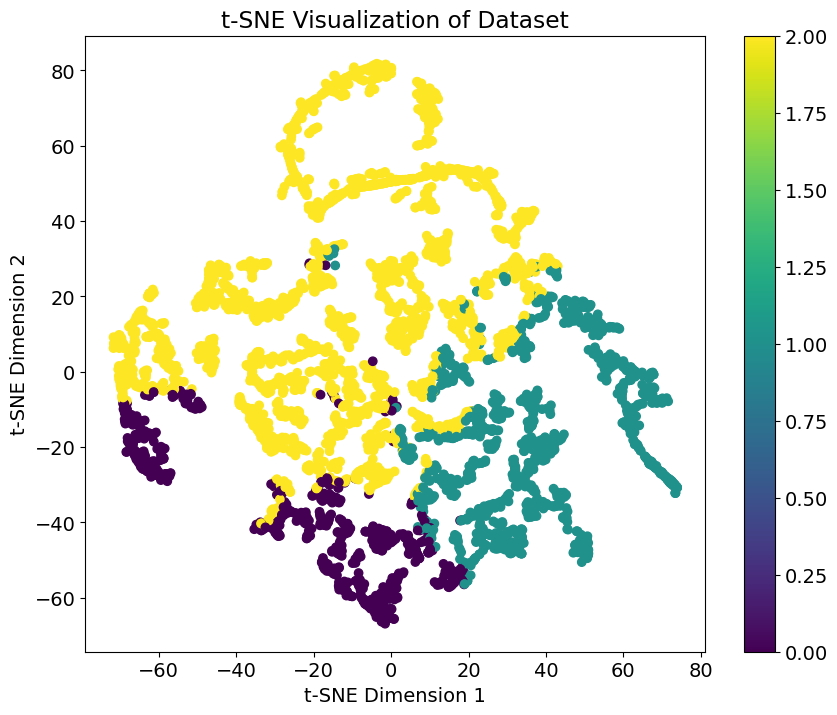

In [16]:
# Step 1: Instantiate the t-SNE model
tsne_model = TSNE(n_components=2, random_state=42)

# Step 2: Fit and transform your data using t-SNE
embedded_data = tsne_model.fit_transform(cont_grp[:5000])

# Step 3: Create a scatter plot to visualize the embedded data
plt.figure(figsize=(10, 8))
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=labels[:5000], cmap='viridis', marker='o')
plt.colorbar()
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [17]:
def ctrl_grp_stats_com(data, var=None):
    stat_dict = {'share': data.wt_p.sum() / df_exp.wt_p.sum() * 100}
    wdf = DescrStatsW(data[var], weights=data['wt_p'], ddof=1)
    sts = wdf.quantile([0.25,0.50,0.75])
    q25 = sts.values[0]
    q50 = sts.values[1]
    q75 = sts.values[2]
    stat_dict['mean'] = wdf.mean
    stat_dict['q25'] = q25
    stat_dict['q50'] = q50
    stat_dict['q75'] = q75
    stat_dict['var'] = var
    return pd.Series(stat_dict)

def ctrl_grp_stats_calculation(df=None, focus_thr=False):
    if focus_thr:
        df_exp = df.loc[df['deso_2'].isin(['01', '12', '14']), :]
    else:
        df_exp = df.copy()
    list_df_ctrl = []
    for var in ['Lowest income group', 'car_ownership', 'radius_of_gyration']:
        list_df_ctrl.append(df_exp.groupby(['ctrl_grp']).
                           apply(lambda x: ctrl_grp_stats_com(x, var)).
                           reset_index())
    df_ctrl = pd.concat(list_df_ctrl)
    if focus_thr:
        df_ctrl.loc[:, 'focus'] = 'yes'
    else:
        df_ctrl.loc[:, 'focus'] = 'no'
    return df_ctrl

In [18]:
df_ctrl = ctrl_grp_stats_calculation(df=df_exp, focus_thr=False)
df_ctrl

,ctrl_grp,share,mean,q25,q50,q75,var,focus
0,0,21.583476,0.181314,0.000000,0.180328,0.291667,Lowest income group,no
1,1,26.293054,0.488156,0.377907,0.453913,0.553846,Lowest income group,no
2,2,52.123470,0.152678,0.083333,0.153846,0.226829,Lowest income group,no
0,0,21.583476,0.842109,0.711744,0.819959,0.931223,car_ownership,no
1,1,26.293054,0.434770,0.296249,0.432551,0.546956,car_ownership,no
2,2,52.123470,0.427584,0.329234,0.445714,0.529452,car_ownership,no
0,0,21.583476,66.948301,11.188224,37.021402,90.362828,radius_of_gyration,no
1,1,26.293054,53.513110,5.341156,23.394685,72.862051,radius_of_gyration,no
2,2,52.123470,81.582578,7.848717,39.144593,105.922445,radius_of_gyration,no


Group 0: "ProsperDrive"

Description: Higher income, higher car ownership, longer mobility range.
Rationale: This name combines "Prosper" to reflect their higher income status and "Drive" to highlight their higher car ownership and extended mobility range.

Group 1: "ThriftyMove"

Description: Lower income, lower car ownership, shorter mobility range.
Rationale: The name "Thrifty" emphasizes their cost-conscious approach due to lower income, and "Move" represents their reliance on more economical mobility options.

Group 2: "EliteWander"

Description: Higher income, lower car ownership, longer mobility range.
Rationale: "Elite" suggests their higher socio-economic status, and "Wander" captures their ability to roam extensively despite not owning cars.

In [19]:
df_exp.to_parquet("results/transport_association/seg_disparity_patterns.parquet")

In [20]:
df_ctrl.to_parquet("results/transport_association/three_travelers.parquet")

Traveler composition by DeSO zone

In [62]:
def grp2vector(data):
    tot = data['wt_p'].sum()
    s = data.groupby('ctrl_grp')['wt_p'].sum() / tot
    return pd.Series(s.to_dict(), index=[0, 1, 2])
df_exp_deso = df_exp.groupby(['region']).apply(lambda x: grp2vector(x)).reset_index().fillna(0)
df_exp_deso.columns= ['deso', 'ProsperDrive', 'ThriftyMove', 'EliteWander']

In [63]:
def vec2rgb2hex(row):
    def clamp(x):
        return max(0, min(round(x*255), 255))
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(row['ThriftyMove']),
                                           clamp(row['EliteWander']),
                                           clamp(row['ProsperDrive']))
df_exp_deso.loc[:, 'color'] = df_exp_deso.apply(lambda row: vec2rgb2hex(row), axis=1)
df_exp_deso.head()

,deso,ProsperDrive,ThriftyMove,EliteWander,color
0,0114A0010,1.0,0.000000,0.000000,#0000ff
1,0114C1010,0.0,0.000000,1.000000,#00ff00
2,0114C1020,0.0,0.000000,1.000000,#00ff00
3,0114C1030,0.0,0.000000,1.000000,#00ff00
4,0114C1040,0.0,0.277778,0.722222,#47b800


In [64]:
df_exp_deso.to_parquet("results/transport_association/three_travelers_deso.parquet")

Traveler composition by living area

In [65]:
values_map = {1: 'ThriftyMove', 0: 'ProsperDrive', 2: 'EliteWander'}
df_exp_rc2 = df_exp.groupby(['region_cat2', 'ctrl_grp'])['wt_p'].sum() / df_exp.wt_p.sum() * 100
df_exp_rc2 = df_exp_rc2.reset_index()
df_exp_rc2.loc[:, 'ctrl_grp'] = df_exp_rc2.loc[:, 'ctrl_grp'].map(values_map)
df_exp_rc2 = df_exp_rc2.rename(columns={'wt_p': 'Share'})
df_exp_rc2

,region_cat2,ctrl_grp,Share
0,Rural/Suburban,ProsperDrive,16.483356
1,Rural/Suburban,ThriftyMove,2.835046
2,Rural/Suburban,EliteWander,3.670102
3,Urban,ProsperDrive,5.100120
4,Urban,ThriftyMove,23.458008
5,Urban,EliteWander,48.453368


In [66]:
df_exp_rc2.to_parquet("results/transport_association/three_travelers_distr.parquet")

### 2.2 Statistics of these groups

In [104]:
df_exp_sstats = df_exp.groupby(['seg_r', 'seg_change', 'ctrl_grp'])['wt_p'].sum() / df_exp.wt_p.sum() * 100
df_exp_sstats = df_exp_sstats.reset_index()
df_exp_sstats.loc[:, 'ctrl_grp'] = df_exp_sstats.loc[:, 'ctrl_grp'].map(values_map)
df_exp_sstats = pd.pivot_table(df_exp_sstats, values='wt_p', index=['ctrl_grp'],
                       columns=['seg_r', 'seg_change'])
df_exp_sstats = df_exp_sstats.reset_index()

In [105]:
df_exp_sstats.loc[:, 'sum'] = df_exp_sstats.apply(lambda row: row[df_exp_sstats.columns[1]] + row[df_exp_sstats.columns[2]] + row[df_exp_sstats.columns[3]] + row[df_exp_sstats.columns[4]], axis=1)
for var in df_exp_sstats.columns[1:5]:
    df_exp_sstats.loc[:, var] /= df_exp_sstats.loc[:, 'sum']
    df_exp_sstats.loc[:, var] *= 100
df_exp_sstats

seg_r           ctrl_grp          D                    F                   sum
seg_change                      dec       inc        dec        inc           
0            EliteWander  67.469000  1.912440   7.791352  22.827208  52.123470
1           ProsperDrive  95.650142  1.346280   0.763584   2.239993  21.583476
2            ThriftyMove  31.530070  1.325374  22.980824  44.163732  26.293054

In [106]:
df_exp_sstats.to_clipboard(index=False)

In [ ]:
df_exp.groupby(['region_cat2'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

In [ ]:
df_exp.groupby(['region_cat2', 'ctrl_grp'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

In [57]:
df_exp.groupby(['seg_r'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

seg_r
D    65.737913
F    34.262087
Name: wt_p, dtype: float64

In [107]:
df_exp.groupby(['seg_r', 'ctrl_grp'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

seg_r  ctrl_grp
D      0           20.935200
       1            8.638700
       2           36.164014
F      0            0.648276
       1           17.654354
       2           15.959456
Name: wt_p, dtype: float64

## 3. Quantify segregation disparity

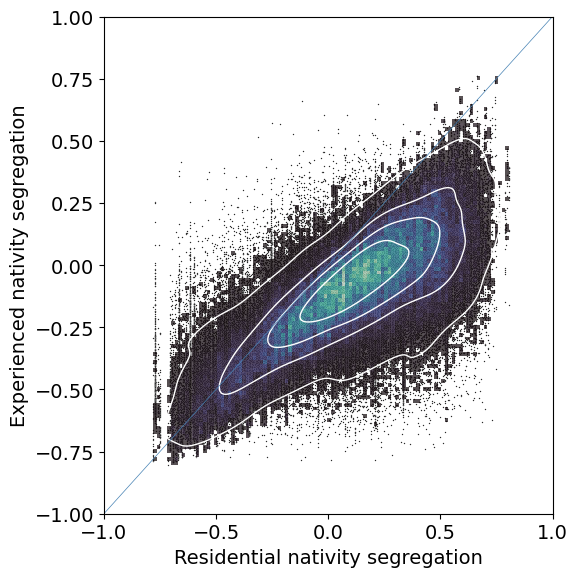

In [95]:
sp = df_exp.sample(10000, random_state=0)
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df_exp, x='ice_birth_resi', y='ice_birth', s=1, color=".15")
sns.histplot(data=df_exp, x='ice_birth_resi', y='ice_birth', weights=df_exp.wt_p,
                 cmap="mako", bins=100, pthresh=.01, alpha=0.7)
sns.kdeplot(data=sp, x='ice_birth_resi', y='ice_birth', weights=sp.wt_p,
            levels=5, color="w", linewidths=1)
ax.plot([-1, 1], [-1, 1], '-', linewidth = 0.5, color='steelblue')
ax.set_xlabel('Residential nativity segregation')
ax.set_ylabel('Experienced nativity segregation')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.tight_layout()
f.savefig("figures/seg_disp_res.png", dpi=300)

### 3.1 Calculate boxplot stats

In [66]:
def seg_grp_stats_com(data, var=None):
    stat_dict = {'share': data.wt_p.sum() / df_exp.wt_p.sum() * 100}
    wdf = DescrStatsW(data[var], weights=data['wt_p'], ddof=1)
    sts = wdf.quantile([0.25,0.50,0.75])
    q25 = sts.values[0]
    q50 = sts.values[1]
    q75 = sts.values[2]
    stat_dict['mean'] = wdf.mean
    stat_dict['q25'] = q25
    stat_dict['q50'] = q50
    stat_dict['q75'] = q75
    stat_dict['var'] = var
    return pd.Series(stat_dict)

def stats_calculation(df=None, focus_thr=False):
    if focus_thr:
        df_exp = df.loc[df['deso_2'].isin(['01', '12', '14']), :]
    else:
        df_exp = df.copy()
    list_df_seg = []
    for var in ['Lowest income group', 'car_ownership', 'cum_jobs', 'cum_stops']:
        list_df_seg.append(df_exp.groupby(['seg_r', 'seg_change', 'region_cat2']).
                           apply(lambda x: seg_grp_stats_com(x, var)).
                           reset_index())
    df_seg = pd.concat(list_df_seg)
    df_seg.loc[:, 'seg_change'] = df_seg['seg_change'].map({'inc': 'Increase',
                                                            'dec': 'Decrease'})
    if focus_thr:
        df_seg.loc[:, 'focus'] = 'yes'
    else:
        df_seg.loc[:, 'focus'] = 'no'
    df_seg.loc[:, 'ctrl_grp'] = 'None'
    return df_seg

def stats_calculation_by_grp(df=None, focus_thr=False):
    if focus_thr:
        df_exp = df.loc[df['deso_2'].isin(['01', '12', '14']), :]
    else:
        df_exp = df.copy()
    list_df_seg = []
    for var in ['cum_jobs', 'cum_stops']:
        list_df_seg.append(df_exp.groupby(['seg_r', 'seg_change', 'region_cat2', 'ctrl_grp']).
                           apply(lambda x: seg_grp_stats_com(x, var)).
                           reset_index())
    df_seg = pd.concat(list_df_seg)
    df_seg.loc[:, 'seg_change'] = df_seg['seg_change'].map({'inc': 'Increase',
                                                            'dec': 'Decrease'})
    if focus_thr:
        df_seg.loc[:, 'focus'] = 'yes'
    else:
        df_seg.loc[:, 'focus'] = 'no'
    df_seg.loc[:, 'ctrl_grp'] = df_seg.loc[:, 'ctrl_grp'].astype(str)
    return df_seg

In [67]:
df_seg = pd.concat([stats_calculation(df=df_exp, focus_thr=False),
                    stats_calculation(df=df_exp, focus_thr=True),
                    stats_calculation_by_grp(df=df_exp, focus_thr=False)])

In [68]:
df_seg.to_parquet('results/transport_association/seg_disarity_patterns_stats.parquet')
df_seg

,seg_r,seg_change,region_cat2,share,mean,q25,q50,q75,var,focus,ctrl_grp
0,D,Decrease,Rural/Suburban,21.311984,0.213918,0.000000,0.187500,0.333333,Lowest income group,no,None
1,D,Decrease,Urban,42.790044,0.186343,0.085714,0.162500,0.260188,Lowest income group,no,None
2,D,Increase,Rural/Suburban,0.310197,0.270702,0.121212,0.230769,0.380952,Lowest income group,no,None
3,D,Increase,Urban,1.325689,0.224804,0.107143,0.216039,0.308311,Lowest income group,no,None
4,F,Decrease,Rural/Suburban,0.311321,0.321306,0.170213,0.338983,0.449324,Lowest income group,no,None
...,...,...,...,...,...,...,...,...,...,...,...
19,F,Increase,Rural/Suburban,0.499193,13.868992,7.000000,12.000000,19.000000,cum_stops,no,1
20,F,Increase,Rural/Suburban,0.353855,12.390516,6.000000,11.000000,20.000000,cum_stops,no,2
21,F,Increase,Urban,0.281515,13.431473,4.000000,9.000000,20.000000,cum_stops,no,0
22,F,Increase,Urban,11.112801,43.076084,15.000000,22.000000,34.000000,cum_stops,no,1


### 3.2 Vislualization
This part is done in `30-1-seg-disp-patterns-cat.R`.

## 4. Weighted Mann–Whitney U test

In [89]:
import os
os.environ['R_HOME'] = "C:\Program Files\R\R-4.0.2"
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as rpyn
from rpy2.robjects.packages import importr
from rpy2.robjects import conversion, default_converter
with conversion.localconverter(default_converter):
    r_weights = importr('survey')

In [94]:
def wmu_test(data=None, region=None, grps=None, var=None, weight=None):
    data1 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'dec'), [var, weight]]
    data2 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'inc'), [var, weight]]
    weights1 = data1[weight].values
    weights2 = data2[weight].values
    weights = np.concatenate([weights1, weights2])
    group1 = data1[var].values
    group2 = data2[var].values
    with conversion.localconverter(default_converter):
        ro.r.assign('group1', rpyn.numpy2rpy(group1))
        ro.r.assign('group2', rpyn.numpy2rpy(group2))
        ro.r.assign('weights', rpyn.numpy2rpy(weights))
        ro.r.assign('weights1', rpyn.numpy2rpy(weights1))
        ro.r.assign('weights2', rpyn.numpy2rpy(weights2))
        ro.r('''data <- data.frame(group = c(group1, group2),
                        group_indicator = rep(c(1, 2), c(length(group1), length(group2))))''')
        ro.r('''design <- svydesign(ids = ~0, data = data, weights = ~weights)''')
        ro.r('''result <- svyranktest(formula = group ~ group_indicator, design=design, test = "wilcoxon")''')
        ro.r('''est <- unname(result$estimate)''')
        ro.r('''pvalue <- unname(result$p.value)''')
        est = ro.globalenv['est'][0]
        pvalue = ro.globalenv['pvalue'][0]
    return est, pvalue

In [110]:
def cohen_d(data=None, region=None, grps=None, var=None, weight=None):
    data1 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'dec'), [var, weight]]
    data2 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'inc'), [var, weight]]
    wdf1 = DescrStatsW(data1[var], weights=data1['wt_p'], ddof=1)
    wdf2 = DescrStatsW(data2[var], weights=data2['wt_p'], ddof=1)
    diff = wdf1.mean - wdf2.mean
    pooledstdev = np.sqrt((wdf1.std**2 * (data1['wt_p'].sum() - 1) + wdf2.std**2 * (data2['wt_p'].sum() - 1))/
                          (data1['wt_p'].sum() + data2['wt_p'].sum() - 2) )
    cohend = diff / pooledstdev
    return cohend

def eff_size(x):
    if abs(x) < 0.2:
        return 'Very small'
    elif 0.2 <= abs(x) < 0.5:
        return 'Small'
    elif 0.5 <= abs(x) < 0.8:
        return 'Medium'
    return 'Large'

### 4.1 By variable

In [54]:
weight = 'wt_p'
res_list = []
for var in ['Lowest income group', 'car_ownership', 'cum_jobs', 'cum_stops']:
    for rg in ['Rural/Suburban', 'Urban']:
        for grp in ['D', 'F']:
            est, pvalue = wmu_test(data=df_exp, region=rg, grps=grp, var=var, weight=weight)
            grp_type = grp[0]
            if pvalue > 0.001:
                sig = '-'
            else:
                sig = '*'
            res_list.append((var, rg, grp_type, pvalue, sig, est))
df_res = pd.DataFrame(res_list, columns=['var', 'region_cat', 'seg_r', 'p', 'sig', 'difference in mean rank score'])
df_res

,var,region_cat,seg_r,p,sig,difference in mean rank score
0,Lowest income group,Rural/Suburban,D,5.186499e-11,*,0.080746
1,Lowest income group,Rural/Suburban,F,2.091690e-01,-,0.015946
2,Lowest income group,Urban,D,6.395267e-28,*,0.078795
3,Lowest income group,Urban,F,7.696441e-242,*,-0.081125
4,car_ownership,Rural/Suburban,D,5.884797e-49,*,-0.185375
5,car_ownership,Rural/Suburban,F,1.280281e-02,-,0.031118
6,car_ownership,Urban,D,8.417796e-07,*,0.029937
7,car_ownership,Urban,F,0.000000e+00,*,0.115664
8,cum_jobs,Rural/Suburban,D,2.351337e-01,-,-0.013540
9,cum_jobs,Rural/Suburban,F,5.999118e-02,-,0.025914


In [40]:
df_res.to_clipboard(index=False)

In [55]:
df_res.to_parquet('results/transport_association/stats_test.parquet')

### 4.2 By groups of income, car ownership, and mobility range

In [111]:
weight = 'wt_p'
res_list = []
for var in ['cum_jobs', 'cum_stops']:
    for rg in ['Rural/Suburban', 'Urban']:
        for ctrl in [0, 1, 2]:
            for grp in ['D', 'F']:
                est, pvalue = wmu_test(data=df_exp.loc[df_exp['ctrl_grp']==ctrl, :],
                                                region=rg, grps=grp, var=var, weight=weight)
                cohend = cohen_d(data=df_exp.loc[df_exp['ctrl_grp']==ctrl, :],
                                 region=rg, grps=grp, var=var, weight=weight)
                grp_type = grp[0]
                if pvalue > 0.001:
                    sig = '-'
                else:
                    sig = '*'
                res_list.append((var, rg, str(ctrl), grp_type, pvalue, sig, est, cohend))
df_res = pd.DataFrame(res_list, columns=['var', 'region_cat2', 'ctrl_grp', 'seg_r', 'p', 'sig', 'difference in mean rank score', 'cohen_d'])
df_res.loc[:, 'effsize'] = df_res.loc[:, 'cohen_d'].apply(lambda x: eff_size(x))
df_res

,var,region_cat2,ctrl_grp,seg_r,p,sig,difference in mean rank score,cohen_d,effsize
0,cum_jobs,Rural/Suburban,0,D,4.585783e-05,*,-0.064248,0.297170,Small
1,cum_jobs,Rural/Suburban,0,F,3.603199e-19,*,0.238064,-0.347811,Small
2,cum_jobs,Rural/Suburban,1,D,1.590033e-01,-,-0.034813,0.138128,Very small
3,cum_jobs,Rural/Suburban,1,F,1.004670e-05,*,-0.085486,0.259838,Small
4,cum_jobs,Rural/Suburban,2,D,3.148916e-05,*,-0.096917,0.208080,Small
5,cum_jobs,Rural/Suburban,2,F,2.115025e-02,-,0.060832,-0.191854,Very small
6,cum_jobs,Urban,0,D,7.786420e-07,*,-0.095903,0.087930,Very small
7,cum_jobs,Urban,0,F,5.202093e-01,-,0.012942,-0.240099,Small
8,cum_jobs,Urban,1,D,8.358951e-05,*,-0.049252,0.143685,Very small
9,cum_jobs,Urban,1,F,6.862403e-17,*,-0.025664,0.116868,Very small


In [112]:
df_res.to_parquet('results/transport_association/stats_test_ctrl_grp.parquet')

## 5. EBM model predicting segregation gap

In [37]:
def ebm_group(data, title='Test', weight_field=None, shap_size=500):
#    data = pd.get_dummies(data, columns=['region_cat'], prefix='region_cat_', prefix_sep='')
    data = data.rename(columns={'car_ownership': 'Car ownership (/capita)',
                                'cum_jobs': 'Car accessibility to jobs',
                                'cum_stops': 'Access to transit stops'})
    predictors = ['Lowest income group', 'Car ownership (/capita)',
                  'Car accessibility to jobs', 'Access to transit stops']

    target_column = 'seg_gap'
    X = data[predictors]
    y = data[target_column]
    sample_weight = data[weight_field]

    X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(X, y, sample_weight, test_size=0.00001, random_state=40)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    seed = 1
    ebm = ExplainableBoostingRegressor(interactions=3, random_state=seed, feature_names=predictors, outer_bags=2)
    ebm.fit(X_train, y_train, sample_weight=weight_train)
    # explain the GAM model with SHAP
    background = shap.maskers.Independent(X_train, max_samples=1000)
    explainer_ebm = shap.Explainer(ebm.predict, background)
    shap_values_ebm = explainer_ebm(X_train[:shap_size])
    shap_values_ebm.feature_names = predictors
    # Customize the order of features
    order = predictors
    col2num = {col: i for i, col in enumerate(X.columns)}
    order = list(map(col2num.get, order))
    # Get the current figure and axes objects.
    fig = plt.figure(figsize=(5, 3))
    shap.plots.beeswarm(shap_values_ebm, order=order, show=False, alpha=0.5, log_scale=False)
    # Make the modifications that you want.  I wanted
    # to resize the x-axis, but you can do anything that you'd like.
    plt.title(title)
    # plt.xlim(-0.3, 0.3)
    plt.xlabel('Impact on nativity segregation change')
    plt.tight_layout()
    plt.show()
    fig.savefig(f'figures/ebm/ice_gap_shap_{title.replace("/", "_")}.png', dpi=300)

Exact explainer: 10001it [00:30, 213.54it/s]                          


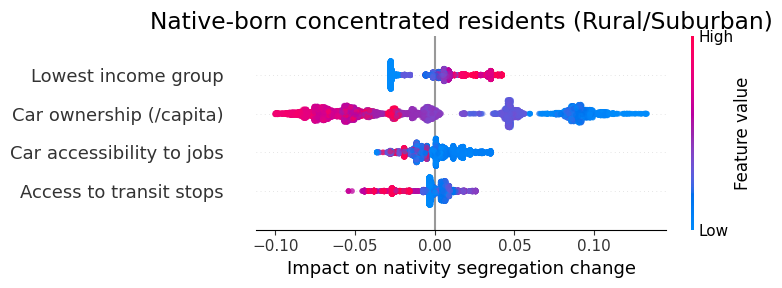

Exact explainer: 10001it [00:30, 211.70it/s]                          


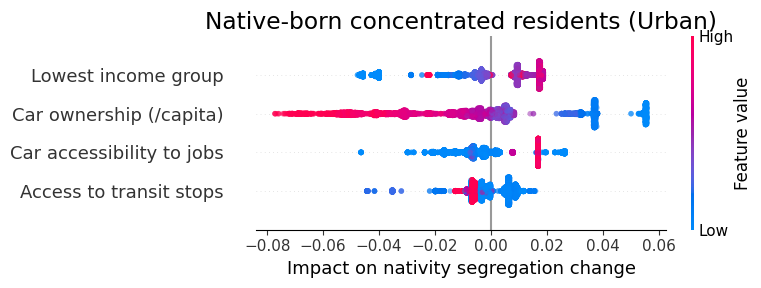

Exact explainer: 3927it [00:10, 19.52it/s]                           


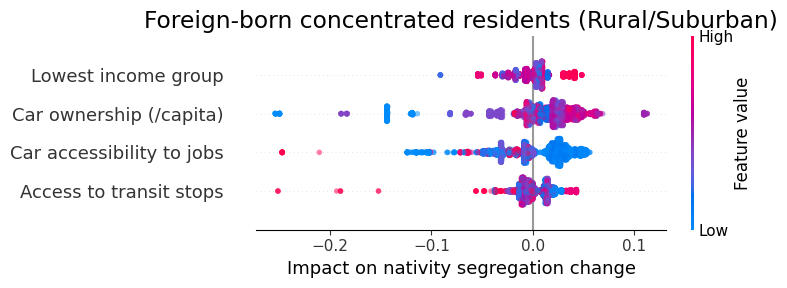

Exact explainer: 10001it [00:29, 213.79it/s]                          


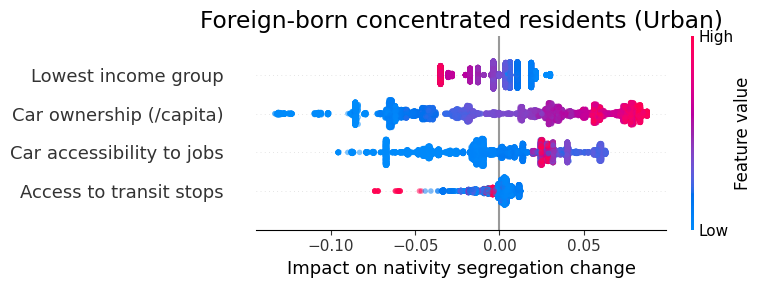

In [38]:
seg_dict = {'D': 'Native-born concentrated residents',
            'F': 'Foreign-born concentrated residents'}
for grp, df in df_exp.groupby(['seg_r', 'region_cat2']):
    title = seg_dict[grp[0]] + f' ({grp[1]})'
    ebm_group(df, title=title, weight_field='wt_p', shap_size=10000)